In [57]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci
from pydub import AudioSegment
import torch
import math

In [58]:
import os
from io import BytesIO
import numpy as np
import scipy.io.wavfile

In [59]:
# Create dataframe
path = Path("data")
ep = "e01"
audio_dir = Path("data/audio/wav/segments")/ep
annotations_path = audio_dir/"labels.json"
df = pd.read_json(annotations_path)
df['actor'] = df.actor.apply(lambda x: '<unk>' if x is None else x)
df.head()

duration  end_time  episode_id   seg_type  start_time             tag  \
0      0.68     45.49           1  character       44.81    Gene Belcher   
1      2.48     48.05           1  character       45.57    Tina Belcher   
2      2.14     36.29           1  character       34.15     Bob Belcher   
3      1.68     37.97           1  character       36.29  Louise Belcher   
4      1.69     39.66           1  character       37.97    Gene Belcher   

  episode                     wav  segment_idx segment_wav       character  \
0     e01  data/audio/wav/e01.wav            0   seg_0.wav    Gene Belcher   
1     e01  data/audio/wav/e01.wav            1   seg_1.wav    Tina Belcher   
2     e01  data/audio/wav/e01.wav            2   seg_2.wav     Bob Belcher   
3     e01  data/audio/wav/e01.wav            3   seg_3.wav  Louise Belcher   
4     e01  data/audio/wav/e01.wav            4   seg_4.wav    Gene Belcher   

             actor  
0    Eugene Mirman  
1        Dan Mintz  
2  H. Jon Benjamin  
3   Kristen Schaal  
4    Eugene Mirman

In [60]:
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512)
a2s = AudioToSpec.from_cfg(cfg)

/home/skander/.cache/pypoetry/virtualenvs/ml-L4gBokpX-py3.9/lib/python3.9/site-packages/torchaudio/functional/functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


In [61]:
cfg

BasicMelSpectrogram(sample_rate=16000, n_fft=512, win_length=None, hop_length=None, f_min=0.0, f_max=None, pad=0, n_mels=128, window_fn=<built-in method hann_window of type object at 0x7fdde9e319a0>, power=2.0, normalized=False, wkwargs=None, center=True, pad_mode='reflect', onesided=True, norm=None, mel_scale='htk', mel=True, to_db=True)

In [62]:
# Various tests
# seg = AudioSegment.from_wav("data/audio/wav/e01.wav")[37970:39660]
# signal = seg.raw_data
# seg.frame_rate
# channel_sounds = seg.split_to_mono()
# samples = [s.get_array_of_samples() for s in channel_sounds]
# fp_arr = np.array(samples).T.astype(np.float32)
# fp_arr /= np.iinfo(samples[0].typecode).max
# tensor = AudioTensor(fp_arr)
# tensor
# wav_io = BytesIO()
# scipy.io.wavfile.write(wav_io, seg.frame_rate, fp_arr)
# wav_io.seek(0)
# torchaudio.load(wav_io)

In [82]:
def get_audio(df):
    wav = df['wav']
    startms = Int(df['start_time'] * 1000)
    endms = Int(df['end_time'] * 1000) # not used until I can figure out resizing in the tfms
    segment_length_ms = 500
    lengthms = Int(df['duration'] * 1000)
    offset = math.floor(max(0, lengthms - segment_length_ms) * np.random.uniform())
    newstart = startms + offset
    newend = min(startms + segment_length_ms, endms)
    print('old/newstart', startms, newstart)
    print('old/newend', startms+segment_length_ms, newend)
    segment = AudioSegment.from_wav(wav)[newstart:]
#     segment = AudioSegment.from_wav(wav)[startms:startms+1000]
    segment = segment.set_frame_rate(16000)
    channel_sounds = segment.split_to_mono()
    samples = [s.get_array_of_samples() for s in channel_sounds]
    fp_arr = np.array(samples).T.astype(np.float32)
    fp_arr /= np.iinfo(samples[0].typecode).max
    wav_io = BytesIO()
    scipy.io.wavfile.write(wav_io, segment.frame_rate, fp_arr)
    wav_io.seek(0)
    return wav_io

In [83]:
auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_x = get_audio, 
                 splitter = RandomSplitter(seed=42),
                 batch_tfms = [a2s],
                 get_y = ColReader("actor"))

In [84]:
dbunch = auds.dataloaders(df, bs=64)

old/newstart 1036450 1037110
old/newend 1036950 1036950
old/newstart 1036450 1036680
old/newend 1036950 1036950


In [85]:
dbunch.show_batch(figsize=(10, 5))

old/newstart 520380 523348
old/newend 520880 520880
old/newstart 77090 77362
old/newend 77590 77590
old/newstart 934240 935611
old/newend 934740 934740
old/newstart 827900 828261
old/newend 828400 828400
old/newstart 1081100 1081493
old/newend 1081600 1081600
old/newstart 305870 305870
old/newend 306370 306280
old/newstart 164100 164300
old/newend 164600 164600
old/newstart 473260 476422
old/newend 473760 473760
old/newstart 1188590 1190669
old/newend 1189090 1189090
old/newstart 346800 346824
old/newend 347300 347300
old/newstart 1179490 1179963
old/newend 1179990 1179990
old/newstart 967140 968836
old/newend 967640 967640
old/newstart 36290 37339
old/newend 36790 36790
old/newstart 860120 862185
old/newend 860620 860620
old/newstart 215650 215801
old/newend 216150 216150
old/newstart 657810 658125
old/newend 658310 658310
old/newstart 1156460 1156463
old/newend 1156960 1156960
old/newstart 940920 941634
old/newend 941420 941420
old/newstart 618490 619058
old/newend 618990 618990
old/

RuntimeError: Error when trying to collate the data into batches with fa_collate, at least two tensors in the batch are not the same size.

Mismatch found on axis 0 of the batch and is of type `AudioTensor`:
	Item at index 0 has shape: torch.Size([1, 13164736])
	Item at index 1 has shape: torch.Size([1, 20300512])

Please include a transform in `after_item` that ensures all data of type AudioTensor is the same size

In [27]:
learn = vision_learner(dbunch, 
            resnet18,
            n_in=1,  # <- This is the only audio specific modification here
            loss_func=CrossEntropyLossFlat(),
            metrics=[accuracy])

In [28]:
@skip_if_ci
def run_learner():
    # epochs are a bit longer due to the chosen melspectrogram settings
    learn.fine_tune(10)

In [29]:
run_learner()

In [30]:
run_learner()

In [34]:
learn.fine_tune(20)

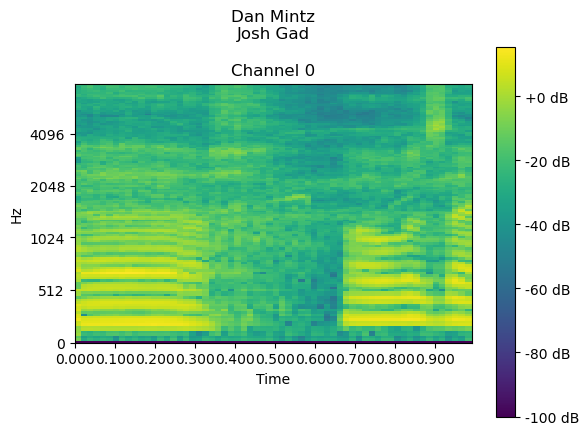

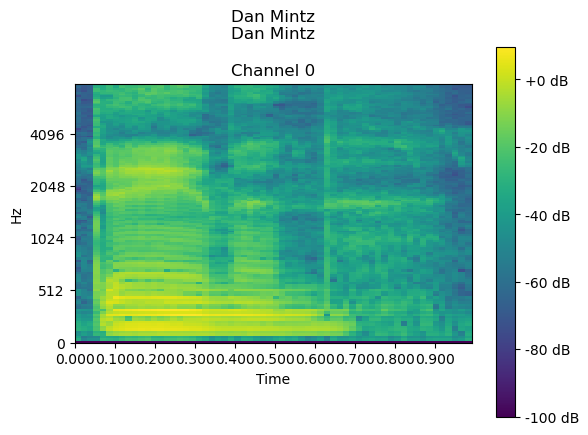

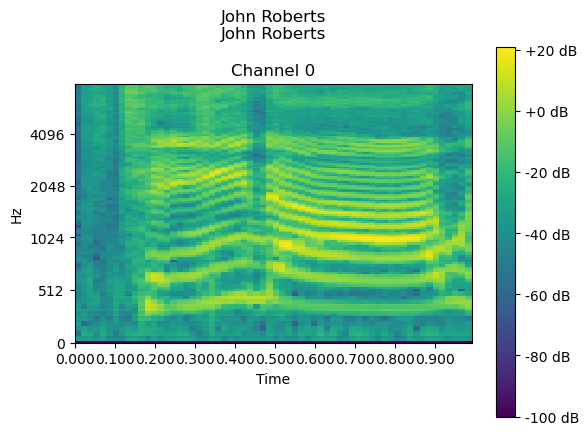

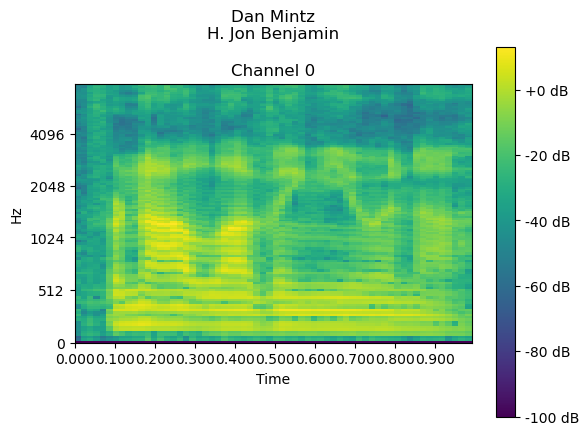

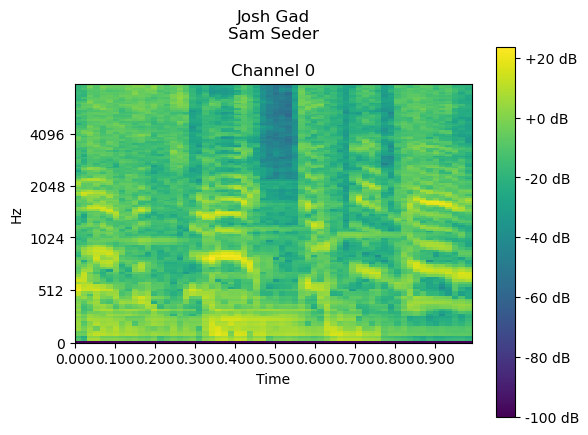

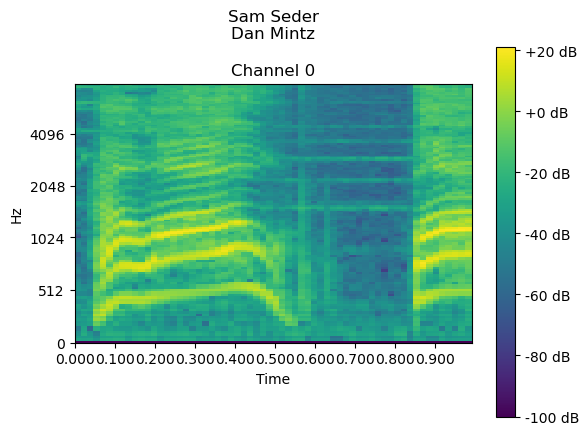

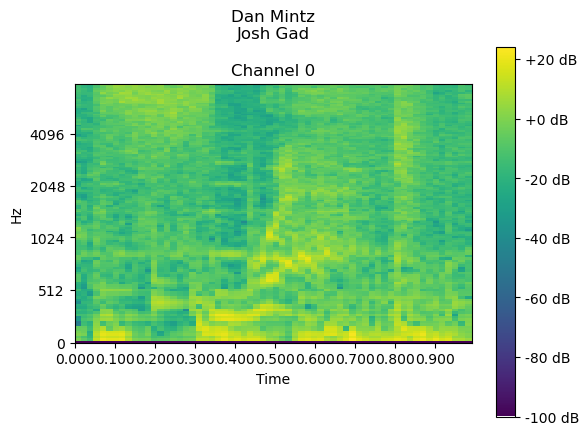

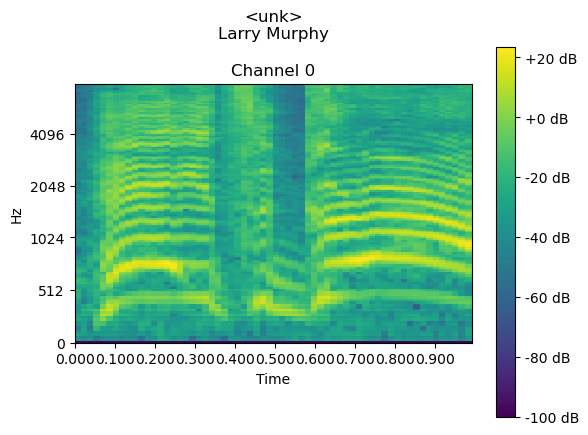

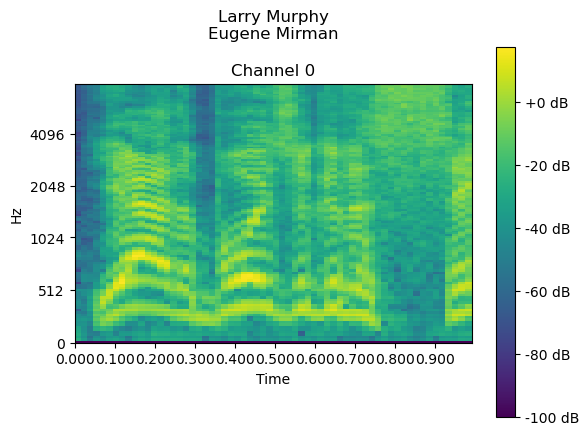

In [35]:
learn.show_results()

In [50]:
learn.save('bobcat_fastaudio')

Path('models/bobcat_fastaudio.pth')